# Model Presentation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm, tree

from keras import Sequential
from keras.layers import Dense, Dropout, LSTM, Masking
from keras.callbacks import ModelCheckpoint

from support_functions import *
from batch_generators import *

Using TensorFlow backend.


In [2]:
#Import data and give column names

train = pd.read_csv('../../data/feature_selected_train_FD001.csv', sep=',', header=0, engine='python')
test = pd.read_csv('../../data/feature_selected_test_FD001.csv', sep=',', header=0, engine='python')
y_test = pd.read_csv('../../data/RUL_FD001.csv', sep=',', header=0,  engine='python')

index_names = train.columns[[0, 1]]
setting_names = train.columns[[2]]
sensor_names = train.drop(index_names.union(setting_names), axis = 1).columns # Find something better than union!!
scale_columns = sensor_names
keep_columns = scale_columns.union(index_names[[1]])

In [3]:
#Data prep for different models
def data_prep(scikit, mlp, train, test, keep_columns, scale_columns, sequence_length):
    if scikit:
        x_train = add_remaining_useful_life(train)
        y_train = x_train.pop('RUL')
        x_test = test.groupby(by="unit_no").last().reset_index()
        x_train_scaled, x_test_scaled = scale_data(x_train, x_test, scale_columns)
        return x_train_scaled[keep_columns], y_train, x_test_scaled[keep_columns]
    else:
        if mlp:
            x_train = add_remaining_useful_life(train)
            x_train_scaled, x_test_scaled = scale_data(x_train, test, scale_columns)
            gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=1) 
            x_train, y_train, x_val, y_val = train_val_group_split(x_train_scaled.drop(['RUL'], axis = 1),
                                                                   x_train_scaled[['RUL', 'unit_no']],
                                                                   gss, x_train_scaled['unit_no'])
            x_test = x_test_scaled.groupby(by="unit_no").last().reset_index()

            y_train = y_train.drop(['unit_no'], axis = 1)
            y_val = y_val.drop(['unit_no'], axis = 1)
            return x_train[keep_columns], y_train, x_val[keep_columns], y_val, x_test[keep_columns]
        else:
            x_train = add_remaining_useful_life(train)
            x_train_scaled, x_test_scaled = scale_data(x_train, test, scale_columns)
            #data = scale_data(data, scale_columns)
            gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=1) 
            x_train, y_train, x_val, y_val = train_val_group_split(x_train_scaled.drop(['RUL'], axis = 1),
                                                                   x_train_scaled[['RUL', 'unit_no']],
                                                                   gss, x_train_scaled['unit_no'])

            generator_x_train = generator_training_wrapper(x_train, sequence_length, keep_columns)
            generator_x_val = generator_training_wrapper(x_val, sequence_length, keep_columns)

            generator_y_train = generator_label_wrapper(y_train, sequence_length, ['RUL'])
            generator_y_val = generator_label_wrapper(y_val, sequence_length, ['RUL'])
            
            generator_x_test = generator_test_wrapper(x_test_scaled, sequence_length, keep_columns)
            return generator_x_train, generator_y_train, generator_x_val, generator_y_val, generator_x_test

In [4]:
def mlp(keep_columns):
    model = Sequential()
    model.add(Dense(128, input_dim = len(keep_columns), activation = 'relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    model.summary()
    return model

In [5]:
def lstm(keep_columns):
    model = Sequential()
    model.add(Masking(mask_value = -99., input_shape=(None, len(keep_columns))))
    model.add(LSTM(256, activation='sigmoid', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mean_squared_error', optimizer = 'adam')
    model.summary()
    return model

In [6]:
models = [
          ('Linear Regression', LinearRegression()),  
          ('SVM', svm.SVR(kernel = 'poly', gamma = 0.0001, C = 10, epsilon= 0.5)),
          ('Random Forest', RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=0,
                           min_samples_leaf=11, min_impurity_decrease=0.0, 
                           max_depth=15, ccp_alpha=0.125)),
          ('MLP', mlp(keep_columns)),
          ('LSTM', lstm(keep_columns))
         ]
results = []
names = []
plot_data_list = []
for name, model in models:
    print(name)
    if(name == 'MLP'):
        x_train, y_train, x_val, y_val, x_test = data_prep(False, True, train, test, keep_columns, scale_columns, 120)
        model.fit(x_train, y_train,
                    validation_data = (x_val, y_val),
                    epochs = 100,
                    batch_size=128)
        
        y_hat_train = model.predict(x_train)
        rmse_train, variance_train = evaluate(y_train, y_hat_train, 'train')

        y_hat_test = model.predict(x_test)
        rmse_test, variance_test = evaluate(y_test, y_hat_test)

        plot_data = [y_train, y_hat_train, y_test, y_hat_test]
        plot_data_list.append(plot_data)

        metrics = [rmse_train, variance_train, rmse_test, variance_test]
        results.append(metrics)

        names.append(name)
    elif(name =='LSTM'):
        x_train, y_train, x_val, y_val, x_test = data_prep(False, False, train, test, keep_columns,scale_columns, 120)
        model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=100,
                        batch_size=128)
                        
        
        y_hat_train = model.predict(x_train)
        rmse_train, variance_train = evaluate(y_train, y_hat_train, 'train')

        y_hat_test = model.predict(x_test)
        rmse_test, variance_test = evaluate(y_test, y_hat_test)

        plot_data = [y_train, y_hat_train, y_test, y_hat_test]
        plot_data_list.append(plot_data)

        metrics = [rmse_train, variance_train, rmse_test, variance_test]
        results.append(metrics)

        names.append(name)
    else:
        x_train, y_train, x_test = data_prep(True, False, train, test, keep_columns,scale_columns, 120)
        clf = model.fit(x_train, y_train)
        y_hat_train = clf.predict(x_train)
        rmse_train, variance_train = evaluate(y_train, y_hat_train, 'train')

        y_hat_test = clf.predict(x_test)
        rmse_test, variance_test = evaluate(y_test, y_hat_test)

        plot_data = [y_train, y_hat_train, y_test, y_hat_test]
        plot_data_list.append(plot_data)

        metrics = [rmse_train, variance_train, rmse_test, variance_test]
        results.append(metrics)

        names.append(name)
        
    
result_df = pd.DataFrame(results, columns = ['RMSE Train', 'R2 Train', 'RMSE Test', 'R2 Test'])
result_df['Model'] = names

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 12,417
Trainable params: 12,417
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 15)          0         
____________________________

In [9]:
result_df.head()

,RMSE Train,R2 Train,RMSE Test,R2 Test,Model
0,40.434685,0.655388,31.128953,0.438862,Linear Regression
1,49.193698,0.489917,32.426510,0.391107,SVM
2,30.602094,0.802610,25.623812,0.619786,Random Forest
3,38.590081,0.696421,27.570206,0.559830,MLP
4,8.655187,0.963655,16.406348,0.844129,LSTM


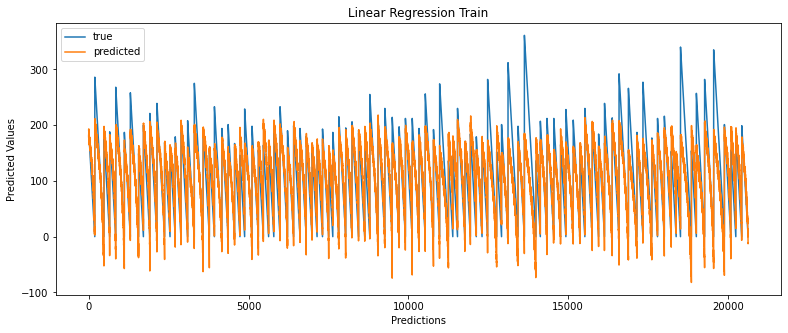

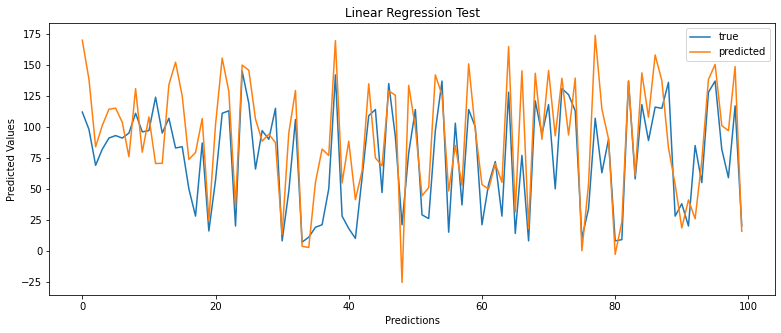

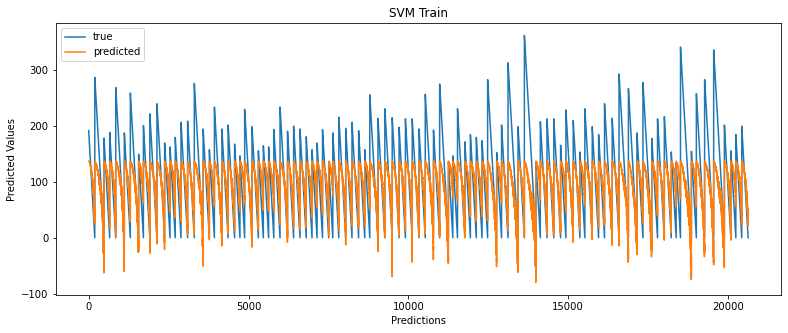

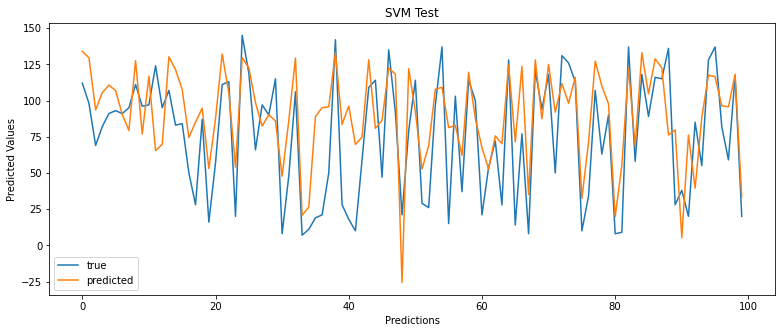

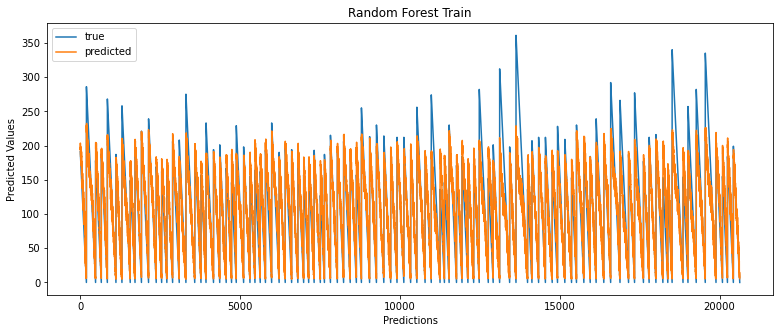

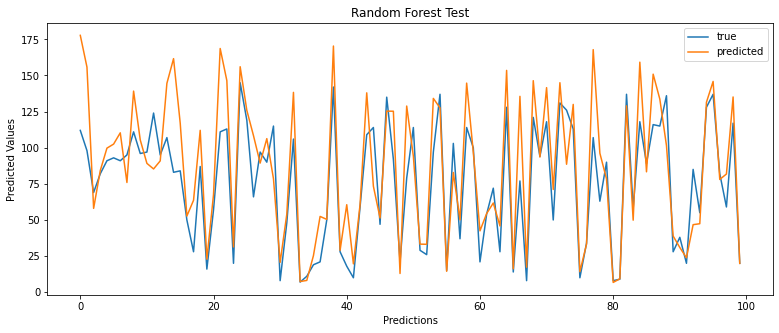

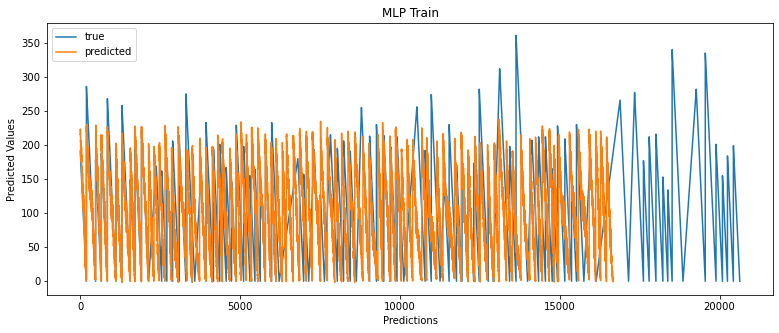

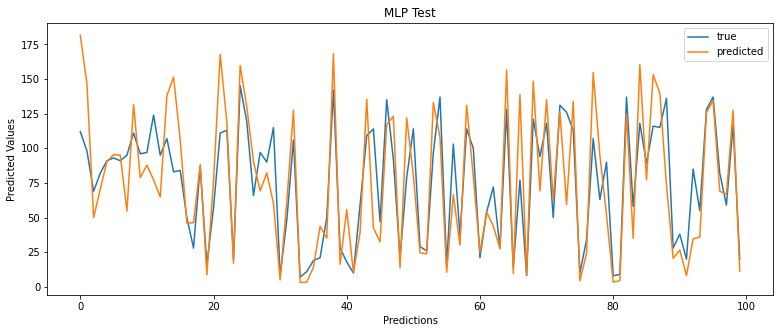

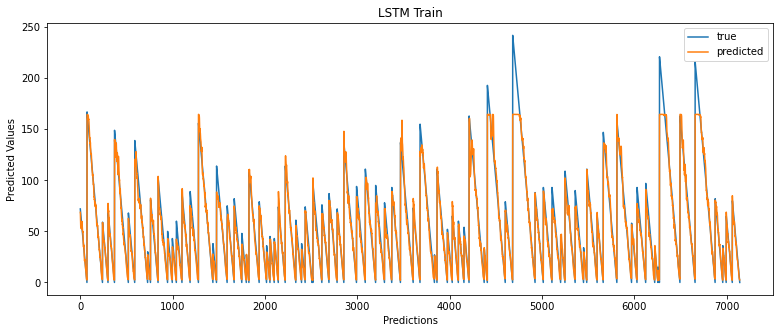

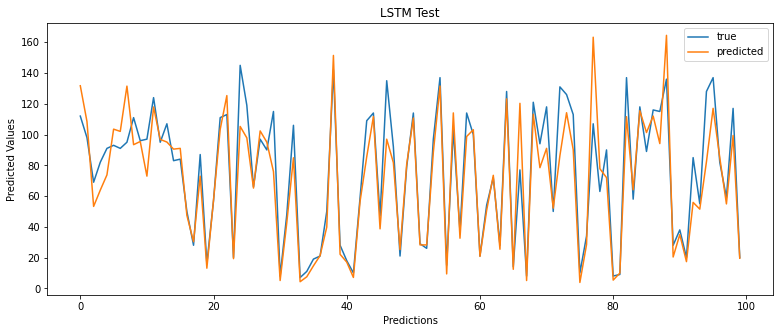

In [8]:
model_plots = ['Linear Regression', 'SVM', 'Random Forest', 'MLP', 'LSTM']
i = 0
for model in model_plots:
    plot_predictions(plot_data_list[i][0], plot_data_list[i][1], label = '{} Train'.format(model))
    plot_predictions(plot_data_list[i][2], plot_data_list[i][3], label = '{} Test'.format(model))
    i = i + 1